In [1]:
# Data
import yfinance as yf
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

# Algorithms
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Model evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Time series
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

# Load data

In [3]:
# Load data

# Amazon vs Microsoft, Google, IBM 
# Daily return past 10 years 
data = yf.download(tickers="AMZN MSFT GOOGL IBM", period='10y', interval='1d')

[*********************100%***********************]  4 of 4 completed


In [4]:
# Save stock data - Close price (adjusted) 

stk_data = data[['Adj Close']]
stk_data.columns = stk_data.columns.droplevel()

In [5]:
stk_data.index

DatetimeIndex(['2011-08-11', '2011-08-12', '2011-08-15', '2011-08-16',
               '2011-08-17', '2011-08-18', '2011-08-19', '2011-08-22',
               '2011-08-23', '2011-08-24',
               ...
               '2021-07-28', '2021-07-29', '2021-07-30', '2021-08-02',
               '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06',
               '2021-08-09', '2021-08-10'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)

In [6]:
# FX and market indices
# Trading dates may vary - will be adjusted

ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = web.DataReader(ccy_tickers, 'fred', start='2011-08-09', end='2021-08-09')
idx_data = web.DataReader(idx_tickers, 'fred', start='2011-08-09', end='2021-08-09')

For modeling, response (Y) and predictor (X) variables will be determined. Amazon stock pricing is the objective of this project. 

The data are represented with daily stock prices, but the response variable (Y) will be the weekly return of Amazon. The number of trading days a week will be assumed to be 5 days.

Independent variables (X) will include stock prices of correlated (likely) companies, market (foreign currency and indices) and lagged stock prices of Amazon. Returns will be rescaled using natural log. Logarithmic price scales tend to show less severe price increases or decreases than linear price scales - so it prevents small price changes being seen more trival than larger counterparts [reference](https://www.investopedia.com/terms/l/logarithmicscale.asp).


The major limitation of this pricing prediction model is that it only concerns correlated stocks and technical indicators, and leaving further investigations with other possible features used in fundamental analysis (i.e. performance reports, news). 



In [7]:
# Construct Y variable - AMZN stock price (5-day)

# To find correlations with other stocks, we need to get 5 day lagged price
# .diff() function produces 5-day returns after natural log rescaling
# .shift() function returns the stock prices that are 5 days later

periods = 5
Y = np.log(stk_data.loc[:, 'AMZN']).diff(periods).shift(-periods)
Y.name = Y.name + '_pred'

In [8]:
stk_data

,AMZN,GOOGL,IBM,MSFT
Date,,,,
2011-08-11,198.360001,281.346344,117.547447,20.185030
2011-08-12,202.300003,282.167175,118.583801,20.112915
2011-08-15,202.949997,278.893890,121.960823,20.441450
2011-08-16,197.679993,269.769775,120.727028,20.441452
2011-08-17,195.929993,266.841827,120.896263,20.360809
...,...,...,...,...
2021-08-04,3354.719971,2702.510010,141.135132,286.510010
2021-08-05,3375.989990,2725.030029,141.145035,289.519989
2021-08-06,3344.939941,2714.770020,142.449997,289.459991


In [9]:
# Construct X variables 

# 5-day returns for Correlated stocks - 'GOOGL', 'IBM', 'MSFT'
X1 = np.log(stk_data.loc[:, ('GOOGL', 'IBM', 'MSFT')]).diff(periods)

# 5-day returns for Foreign currency & Market indices
X2 = np.log(ccy_data).diff(periods)
X3 = np.log(idx_data).diff(periods)

# Lagged 5-day, 15-day, 30-day, 60-day AMZN returns 
X4 = [np.log(stk_data.loc[:, 'AMZN']).diff(i) for i in [periods, periods*3, periods*6,  periods*12]]
X4 = pd.concat(X4, axis=1)
X4.columns = ['AMZN_DT', 'AMZN_3DT', 'AMZN_6DT', 'AMZN_12DT']

In [10]:
# Combine all X variables

X = pd.concat([X1, X2, X3, X4], axis=1)

In [11]:
# Reconstruct dataset with X, Y variables
# Remove row records that contain at least one null values 
# It means that we only contains data corresponding to the dates of Y dataset

dataset = pd.concat([Y, X], axis=1).dropna()

In [12]:
# And also we are interested in seeing a weekly return
# So slicing with 5 day interval

dataset = dataset.iloc[::periods, :]

In [13]:
# Save the data

dataset.to_csv('StockData/PricingAMZN_Technical.csv')

# Descriptive analysis

In [14]:
dataset = pd.read_csv('StockData/PricingAMZN_Technical.csv', index_col=0, parse_dates=True)
dataset.head()

,AMZN_pred,GOOGL,IBM,MSFT,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT
2011-11-04,0.004195,-0.006687,-0.005725,-0.027430,0.031844,-0.006468,-0.025105,-0.020474,0.206620,-0.003873,-0.130715,-0.032405,0.087415
2011-11-14,-0.145683,0.007647,0.004172,-0.001494,-0.013413,-0.007831,-0.007434,0.000877,0.041987,0.008855,-0.081879,0.032260,0.201757
2011-11-22,-0.000260,-0.061128,-0.040215,-0.075720,0.001039,-0.010933,-0.057067,-0.051087,0.023739,-0.124450,-0.097793,-0.202361,-0.071181
2011-11-30,0.015635,0.032884,0.036234,0.031370,0.002194,0.012430,0.070747,0.067667,-0.200736,-0.000260,-0.125445,-0.237672,-0.117107
2011-12-08,-0.049615,0.003708,0.011181,0.004736,0.000902,-0.004021,-0.008254,-0.001859,0.109765,-0.034316,-0.106992,-0.040738,-0.155695


In [15]:
# Get Y, X variables
Y = dataset.loc[:, 'AMZN_pred'].copy()
X = dataset.drop(columns='AMZN_pred').copy()

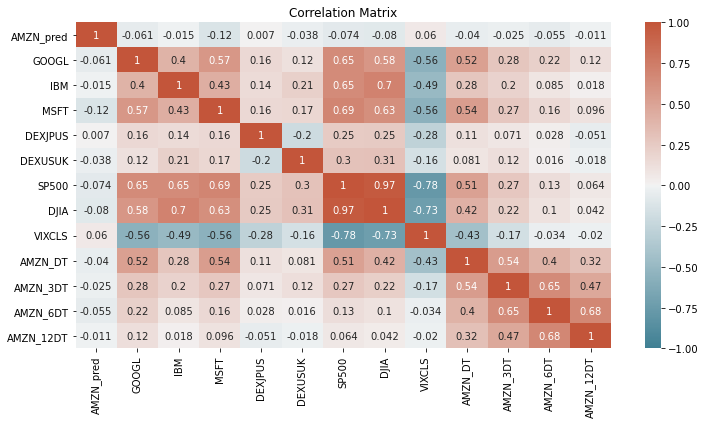

In [16]:
# Heatmap visualization

corr = dataset.corr()
plt.figure(figsize=(12,6))
plt.title('Correlation Matrix')
sns.heatmap(corr, annot=True, cbar=True, vmax=1, vmin=-1, cmap=sns.diverging_palette(220, 20, as_cmap=True)) # diverging
plt.show()

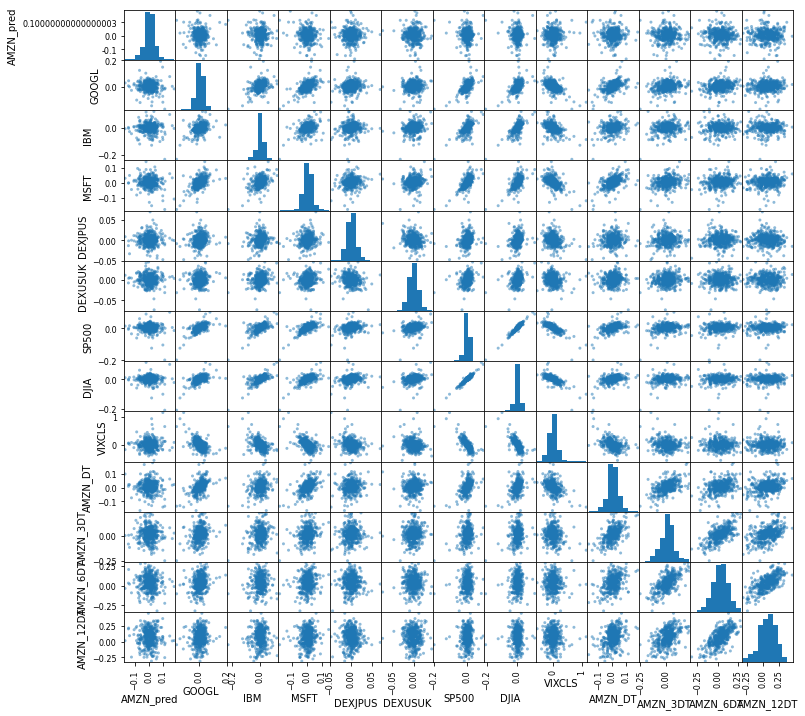

In [17]:
# Scatter plot visualization

scatter_matrix(dataset, figsize=(12,12))
plt.show()

No clear corrleation between AMZN ('AMZN_pred') and other stocks and markets. There are relatively strong negative correlation between VIXCLS and market indices and other stocks. Strong positive correlations are seen amongs lagged returns for Amazon. 

In [18]:
# Time series analysis

def tsa_seasonal_plot(r: pd.Series, period=52):
    model = sm.tsa.seasonal_decompose(r, period=period)
    fig= model.plot()
    fig.set_figheight(8)
    fig.set_figwidth(12)
    plt.show()

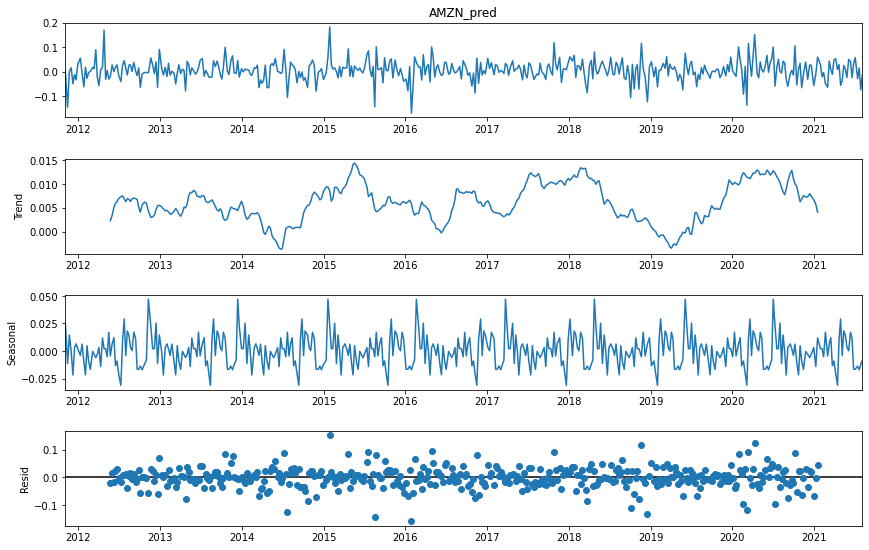

In [19]:
tsa_seasonal_plot(Y);

Amazon stocks have some trend fluctuations in returns. There has been an upward trend in the recent 2 years. The impact of Covid-19 (starting from early 2020) does not seem obvious to Amazon stock price.

# Modeling

It looks that additional data preparation is not necessary with clean and tidy dataset. Returns were log scaled so the additional preprocessing is not needed. Here, not many features are used so dimentional reduction may not be necessary.

In [20]:
# Regressors
# Using default parameters

models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('DT', DecisionTreeRegressor()),
    ('RFR', RandomForestRegressor()),
    ('GBR', GradientBoostingRegressor()),
    ('ABR', AdaBoostRegressor()),
    ('SVR', SVR())
]

In [21]:
dataset

,AMZN_pred,GOOGL,IBM,MSFT,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT
2011-11-04,0.004195,-0.006687,-0.005725,-0.027430,0.031844,-0.006468,-0.025105,-0.020474,0.206620,-0.003873,-0.130715,-0.032405,0.087415
2011-11-14,-0.145683,0.007647,0.004172,-0.001494,-0.013413,-0.007831,-0.007434,0.000877,0.041987,0.008855,-0.081879,0.032260,0.201757
2011-11-22,-0.000260,-0.061128,-0.040215,-0.075720,0.001039,-0.010933,-0.057067,-0.051087,0.023739,-0.124450,-0.097793,-0.202361,-0.071181
2011-11-30,0.015635,0.032884,0.036234,0.031370,0.002194,0.012430,0.070747,0.067667,-0.200736,-0.000260,-0.125445,-0.237672,-0.117107
2011-12-08,-0.049615,0.003708,0.011181,0.004736,0.000902,-0.004021,-0.008254,-0.001859,0.109765,-0.034316,-0.106992,-0.040738,-0.155695
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,0.057439,0.022191,-0.047558,0.046556,0.004503,-0.007511,0.016597,0.010185,-0.035846,0.031690,0.047882,0.077954,0.062185
2021-07-13,-0.028736,0.009084,0.010750,0.011886,-0.002715,0.003980,0.005893,0.008966,0.040530,0.000441,0.062674,0.131861,0.078584
2021-07-20,0.014779,-0.008929,-0.002212,-0.005925,-0.003995,-0.016896,-0.010619,-0.010859,0.141893,-0.028736,0.036857,0.110930,0.067225
2021-07-27,-0.074441,0.044101,0.019667,0.025520,-0.002551,0.019565,0.017973,0.015712,-0.018931,0.014779,-0.013517,0.069218,0.044827


In [22]:
# Train, Test set
# As the dataset is time series,
# split sequentially  

validation_size = .2
split_point = int(dataset.shape[0] * (1-validation_size))
X_train, Y_train = X.iloc[:split_point], Y[:split_point]
X_test, Y_test = X.iloc[split_point:], Y.iloc[split_point:]

In [23]:
# Test for the best model
# Save K fold (10 folds) validation results for analysis
# Evaluate each model wih mean squaredd error

# Set up parameters for KFolds cv
num_folds = 10
scoring = 'neg_mean_squared_error'

names = []
kfold_results = [] # 10 folds cv
train_results = [] # mse
test_results = [] # mse

for name, model in models:
    names.append(name)
    ## Perform K fold test and save results
    kfold = KFold(n_splits=num_folds) 
    cv_results = -cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    ## Fit model and evaluate performances
    fitted = model.fit(X_train, Y_train)
    train_result = mean_squared_error(fitted.predict(X_train), Y_train)
    train_results.append(train_result)
    
    test_result = mean_squared_error(fitted.predict(X_test), Y_test)
    test_results.append(test_result)
    

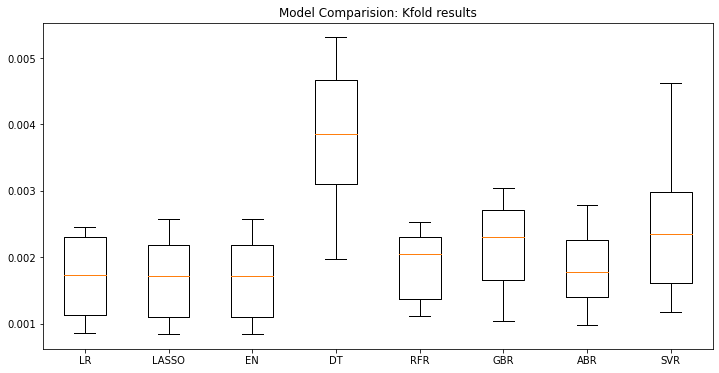

In [24]:
# Plotting the validation results

plt.boxplot(kfold_results)
plt.title('Model Comparision: Kfold results')
plt.xticks(ticks=np.arange(1, len(names)+1, 1), labels=names)
plt.show()

The boxplot shows a distribution of 10 discrete mean squared errors, resulted from kfold cross validations for each model/algorithm. Cross validation was performed on the training set only. So the higher the value, the worse the performance in general.

Linear models (**Linear Regression, LASSO, Elastic net**) performed comparatively better, whereas **ensemble models** are fairly okay. The good performance implies a good relationship between X and Y variable.

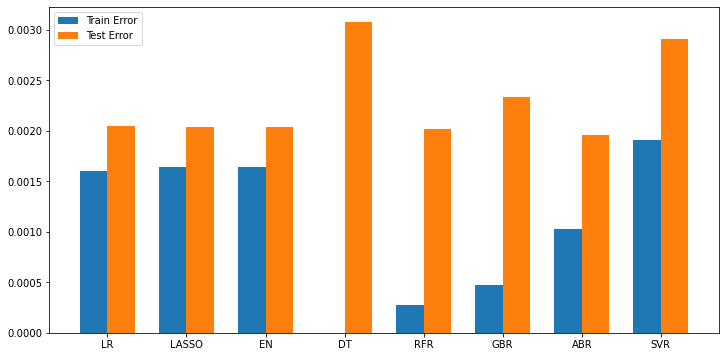

In [25]:
# Plotting the train and test errors

# A good tip to plot both errors in parallel 
loc = np.arange(len(names))
width = .35 

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.bar(loc - width/2, train_results, width=width, label='Train Error')
plt.bar(loc + width/2, test_results, width=width, label='Test Error')

plt.xticks(ticks=loc, labels=names)
plt.legend(loc='best')
plt.show()

**Decision tree** shows a significant issue with overfitting. Ensemble models (**Random forecst, Gradient boost and Ada boost regressors**) also overfit the train data given high test errors compared to train errors. 

Linear models also appears slighly overfit. **Lasso** and **Elastic net** decrease the gaps between train and test errors possibly from regularization.  

## Incorporate ARIMA
For an ARIMA model, lagged variables are not necessary. We fit **ARIMA(1,0,0) = first-order autoregressive model**.

$Ŷ_t = μ + ϕ1Yt-1$

In [26]:
# Remove the lagging features

usecols = X_train.columns.values.tolist()[:-4]
X_train_ARIMA = X_train.loc[:, usecols]
X_test_ARIMA = X_test.loc[:, usecols]

In [27]:
# Fit ARIMA(1,0,0) 
# Assuming no differencing and moving average(error) terms
# The predictor variables X are all exogenous

modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])
modelARIMA_fit = modelARIMA.fit()


/Users/jsuk/opt/anaconda3/envs/ml_fin/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/jsuk/opt/anaconda3/envs/ml_fin/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has bee

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79920D+00    |proj g|=  5.87299D-03

At iterate    5    f= -1.79920D+00    |proj g|=  8.64930D-04

At iterate   10    f= -1.79920D+00    |proj g|=  2.42872D-04

At iterate   15    f= -1.79920D+00    |proj g|=  4.96159D-04

At iterate   20    f= -1.79920D+00    |proj g|=  2.05436D-04

At iterate   25    f= -1.79920D+00    |proj g|=  1.63936D-04

At iterate   30    f= -1.79920D+00    |proj g|=  6.41043D-05

At iterate   35    f= -1.79920D+00    |proj g|=  5.14255D-05

At iterate   40    f= -1.79920D+00    |proj g|=  2.05547D-04

At iterate   45    f= -1.79920D+00    |proj g|=  3.38840D-05

At iterate   50    f= -1.79920D+00    |proj g|=  1.81033D-04

At iterate   55    f= -1.79920D+00    |proj g|=  3.19544D-04

At iterate   60    f= -1.79920D+00    |proj g|=  2.88281D-04

At iterate   65    f= -1.7

In [28]:
# Coefficients

modelARIMA_fit.params

const              0.005104
GOOGL              0.076192
IBM                0.094374
MSFT              -0.230122
DEXJPUS            0.016372
DEXUSUK           -0.037720
SP500              0.792360
DJIA              -0.604528
VIXCLS             0.018995
ar.L1.AMZN_pred   -0.012043
dtype: float64

In [29]:
# Make a prediction with test set

start = len(X_train_ARIMA) - 1
end = len(X) -1
pred_ARIMA = modelARIMA_fit.predict(start=start, end=end, exog=X_test_ARIMA)[1:]
pred_ARIMA

/Users/jsuk/opt/anaconda3/envs/ml_fin/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


371    0.001217
372    0.004511
373    0.008403
374    0.007633
375    0.001751
         ...   
459   -0.001738
460    0.003899
461    0.006996
462    0.008051
463    0.009049
Length: 93, dtype: float64

In [30]:
train_result_ARIMA = mean_squared_error(Y_train, modelARIMA_fit.fittedvalues)
test_result_ARIMA = mean_squared_error(Y_test, pred_ARIMA)

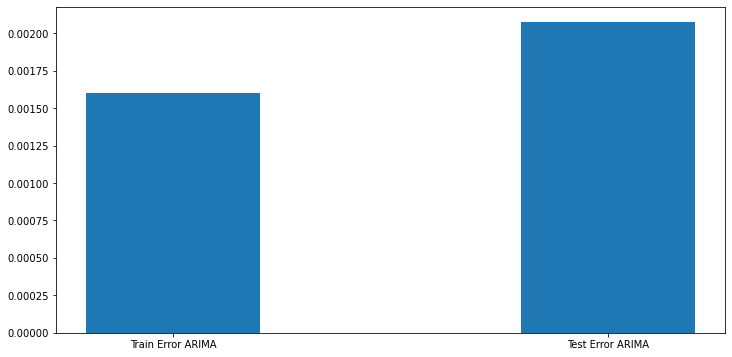

In [31]:
plt.bar(['Train Error ARIMA', 'Test Error ARIMA'], [train_result_ARIMA, test_result_ARIMA], width=0.4);

In [32]:
# Append to the model results

train_results.append(train_result_ARIMA)
test_results.append(test_result_ARIMA)

names.append('ARIMA')

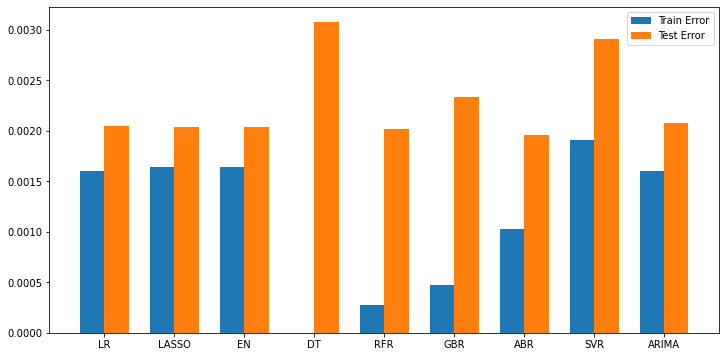

In [33]:
# Plotting the train and test errors

# A good tip to plot both errors in parallel 
loc = np.arange(len(names))
width = .35 

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.bar(loc - width/2, train_results, width=width, label='Train Error')
plt.bar(loc + width/2, test_results, width=width, label='Test Error')

plt.xticks(ticks=loc, labels=names)
plt.legend(loc='best')
plt.show()